**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [8]:
# import packages
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sympy as sm
from scipy import optimize


## 1. <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $C = (1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor


The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

In [9]:
# define symbols
L = sm.symbols('L')
w = sm.symbols('w')
tau = sm.symbols('tau')
G = sm.symbols('G')
alpha = sm.symbols('alpha')
kappa = sm.symbols('kappa')
nu = sm.symbols('nu')
C = sm.symbols('C')
w_tilde = (1-tau)*w

In [10]:
# define utility function using sympy
objective = sm.log((C**alpha)*G**(1-alpha))-nu*L**2/2

# budget constraint as an equality
constraint = sm.Eq(C,kappa+(1-tau)*w*L)

# insert budget constraint into objective function
objective_subs = objective.subs(C,constraint.rhs)

# take derivative of objective function with respect to L
foc = sm.diff(objective_subs,L)

# solve foc for L
L_star = sm.solve(sm.Eq(foc,0),L)[0]
L_star


(kappa*nu - sqrt(nu*(4*alpha*tau**2*w**2 - 8*alpha*tau*w**2 + 4*alpha*w**2 + kappa**2*nu)))/(2*nu*w*(tau - 1))

The above L_star is the solution to the workers labor supply problem. It differs a bit from the provided solution, but it appears that if you multiply with -1 in the denominator and numerator, and using $\tilde w$, then it should simplyfi to the provided solution.

**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.

In [11]:
L_star_sol = (-kappa+sm.sqrt(kappa**2+4*alpha/nu*((1-tau)*w)**2))/(2*(1-tau)*w)


# lambdifi function for optimal labor supply
L_star_func = sm.lambdify(args = (w,tau,alpha,kappa,nu),expr = L_star_sol)





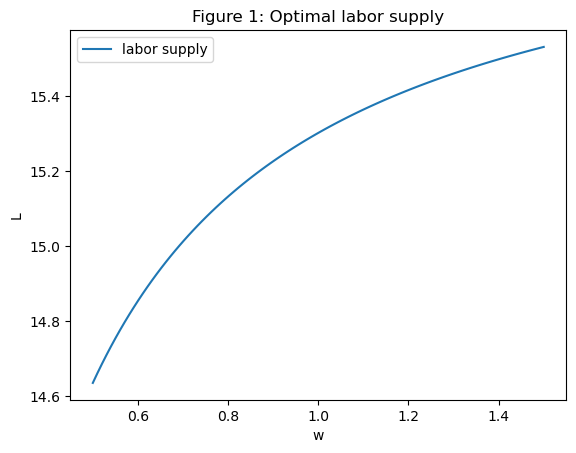

In [12]:
# define parameters
alpha = 0.5
kappa = 1.0
nu = 1/(2*16**2)
w = 1.0
tau = 0.3
G = np.array([1.0,2.0])

L_star_func(w,tau,alpha,kappa,nu)

# make linspace for w
w_vec = np.linspace(0.5,1.5,100)

# plot optimal labor supply for different values of w
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(w_vec,L_star_func(w_vec,tau,alpha,kappa,nu), label = "labor supply") 
ax.set_xlabel('w')
ax.set_ylabel('L')
ax.title.set_text('Figure 1: Optimal labor supply')
ax.legend()
plt.show()



Figure 1 illustrates how $L^*(\tilde w)$ depends on $w$. 

The labour supply is increasing when real wages are higher which corresponds to economic theory.


We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.


We first attempted to solve this problem using sympy and the sm.lambdify() function, where we encountered an error with the log. The workaround is seen below, where we instead define the utility function manually, with the optimal labor supply inserted. 

In [13]:
# define G function
def G_func(w,tau,alpha,kappa,nu):
    return tau*w*(-kappa+np.sqrt(kappa**2+4*alpha/nu*((1-tau)*w)**2))/(2*(1-tau)*w)*((1-tau)*w)

# lambdify G_func
G_func_lambda = lambda w,tau,alpha,kappa,nu: G_func(w,tau,alpha,kappa,nu)


# manual definition of utility function
def objective_v(w,tau,alpha,kappa,nu):
    return np.log(((kappa+(1-tau)*w*((-kappa+np.sqrt(kappa**2+4*alpha/nu*((1-tau)*w)**2))/(2*(1-tau)*w)))**alpha)*G_func(w,tau,alpha,kappa,nu)**(1-alpha))-nu*((-kappa+np.sqrt(kappa**2+4*alpha/nu*((1-tau)*w)**2))/(2*(1-tau)*w))**2/2

# lambdify objective_v
objective_lambda = lambda w,tau,alpha,kappa,nu: objective_v(w,tau,alpha,kappa,nu)





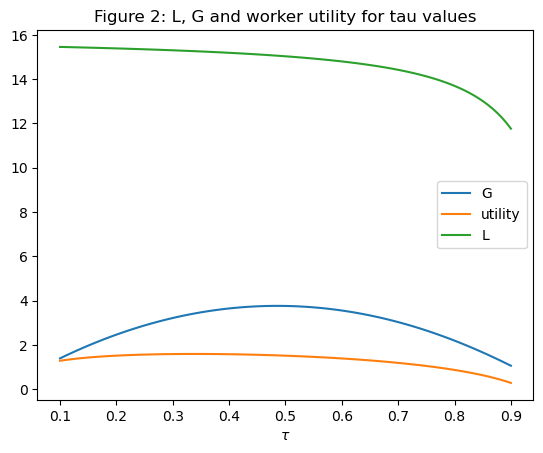

In [14]:
# plotting implied L, G and utility for a grid of tau values

# define tau grid
tau_vec = np.linspace(0.1,0.9,100)

# make 2d plot for G_func_lambda, objective_lambda and L_star_func
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(tau_vec,G_func_lambda(w,tau_vec,alpha,kappa,nu), label = "G")
ax.plot(tau_vec,objective_lambda(w,tau_vec,alpha,kappa,nu), label = "utility")
ax.plot(tau_vec,L_star_func(w,tau_vec,alpha,kappa,nu), label = "L")
ax.set_xlabel(r'$\tau$')
ax.set_title('Figure 2: L, G and worker utility for tau values')
ax.legend()
plt.show()

In figure 2, we see labor supply is decreasing in the tax rate. Worker utility appears to have a slight increase for low values of labor tax. Goverment consumption is initially increasing in the labor tax and then decreasing. The goverment consumption is parabolic. This is similar to the so-called "Laffer-curve". Goverment consumption appears maximized at around 50% labor tax.

**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

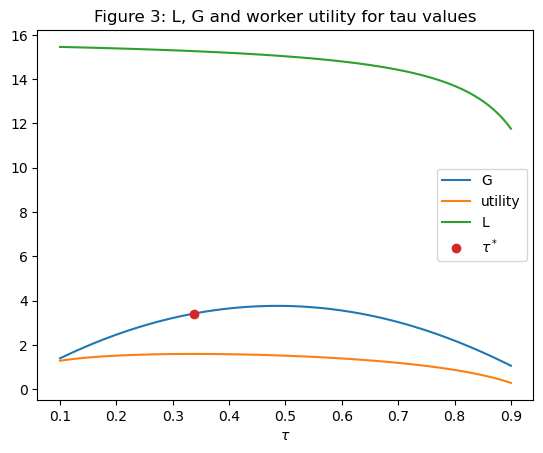

In [26]:
# maximize worker utility using scipy optimize.minimize

objective_lambda_min = lambda tau: -objective_lambda(w,tau,alpha,kappa,nu)
res = optimize.minimize_scalar(objective_lambda_min,method = 'bounded',bounds = (0,1))
tau_star = res.x
tau_star

# plot optimal tau
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(tau_vec,G_func_lambda(w,tau_vec,alpha,kappa,nu), label = "G")
ax.plot(tau_vec,objective_lambda(w,tau_vec,alpha,kappa,nu), label = "utility")
ax.plot(tau_vec,L_star_func(w,tau_vec,alpha,kappa,nu), label = "L")
ax.plot(tau_star,G_func_lambda(w,tau_star,alpha,kappa,nu),'o', label = r'$\tau^*$')
ax.set_xlabel(r'$\tau$')
ax.set_title('Figure 3: L, G and worker utility for tau values')
ax.legend()
plt.show()



A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{1-\sigma} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.

Questions 5 and 6 must be answered with the general formulation, and for 2 different set of parameters:

- Set 1:  $\sigma = 1.001$, $\rho = 1.001$ and $\varepsilon = 1.0$.
- Set 2:  $\sigma = 1.5$, $\rho = 1.5$ and $\varepsilon = 1.0 $.

**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

*Hint: First write code that solves the worker problem for given values of $G$ and $\tau$. Then find the correct G based on this.*

In [16]:
# write your code here

**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.

In [17]:
# write your code here  

## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

In [18]:
# write your code here

We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

In [19]:
# write your code here 

Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

In [20]:
# write your code here

**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

In [21]:
# write your code here


**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



In [22]:
# write your code here

## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

In [23]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.

As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

In [24]:
# write your code here

**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

In [25]:
# write your code here